## Importando paquetes

In [9]:
from datetime import date
from datetime import datetime, timedelta
import math
import pandas as pd
import numpy as np
import statistics
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')
from statsmodels.tsa.api import ExponentialSmoothing

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
#from statsmodels.tsa.api import ExponentialSmoothing
import Time_Series as HW_calibrado
from adjustText import adjust_text
import seaborn as sns

import mod_prediccion as rd_gis

import periodo_critco as ped

import Time_Series as ts_mod



from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge


In [10]:
def output_df_to_pdf(pdf, df):
    # A cell is a rectangular area, possibly framed, which contains some text
    # Set the width and height of cell
    table_cell_width = 25
    table_cell_height = 6
    # Select a font as Arial, bold, 8
    pdf.set_font('Arial', 'B', 8)
    
    # Loop over to print column names
    cols = df.columns
    for col in cols:
        pdf.cell(table_cell_width, table_cell_height, col, align='C', border=1)
    # Line break
    pdf.ln(table_cell_height)
    # Select a font as Arial, regular, 10
    pdf.set_font('Arial', '', 10)
    # Loop over to print each data in the table
    for row in df.itertuples():
        for col in cols:
            value = str(getattr(row, col))
            pdf.cell(table_cell_width, table_cell_height, value, align='C', border=1)
        pdf.ln(table_cell_height)

## Datos de Clima

In [11]:
df_clima = pd.read_excel("C:/Users/Administrador/Documents/Analisis_Datos/Translucidez/CLIMA.xlsx")

In [12]:
df_clima["mes"] = df_clima["mes"].astype("str")
df_clima["año"] = df_clima["año"].astype("str")
df_clima["dia"] = df_clima["dia"].astype("str")
df_clima_BA= df_clima.loc[df_clima["Desc Estacion"] == 'ESTACIÓN 133']

In [13]:
df_clima_BA ["Fecha_R"] = df_clima_BA["mes"] + "/" + df_clima_BA["dia"] + "/" +(df_clima_BA["año"])
df_clima_BA["Fecha_R"] = pd.DatetimeIndex(df_clima_BA["Fecha_R"])
df_clima_BA = df_clima_BA.sort_values(["Fecha_R"])
df_clima_BA ["GDD"] = ((df_clima_BA ["Temp_Max"] +  df_clima_BA ["Temp_Min"])/2) - 12

In [14]:
df_clima_BA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3731 entries, 31562 to 53097
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Desc Estacion  3731 non-null   object        
 1   Semana         3731 non-null   int64         
 2   Fecha          3731 non-null   object        
 3   mes            3731 non-null   object        
 4   dia            3731 non-null   object        
 5   año            3731 non-null   object        
 6   Sum_Lluvia     3731 non-null   float64       
 7   Prom_temp      3731 non-null   float64       
 8   Temp_Min       3731 non-null   float64       
 9   Temp_Max       3731 non-null   float64       
 10  Prom_HR        3731 non-null   float64       
 11  Rad_MJ         3731 non-null   float64       
 12  Rad_Wh         3731 non-null   float64       
 13  Fecha_R        3731 non-null   datetime64[ns]
 14  GDD            3731 non-null   float64       
dtypes: datetime64[ns

In [15]:
print("Fecha Inicial:" , df_clima_BA.Fecha_R.min().date(), 
      "\nFecha Final:" , df_clima_BA.Fecha_R.max().date(),)

Fecha Inicial: 2013-01-01 
Fecha Final: 2023-04-16


## Translucidez 

In [16]:
#Importando base de translucidez BA
df_BA = pd.read_excel("C:/Users/Administrador/Documents/GitHub/Translucidez/Rechazo_Transludidez_BA.xlsx",sheet_name="BAires")
df_BA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4798 entries, 0 to 4797
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Fecha            4798 non-null   datetime64[ns]
 1   Temp_min         4473 non-null   float64       
 2   Temp_max         4473 non-null   float64       
 3   GDD              4473 non-null   float64       
 4   Precipitación    4473 non-null   float64       
 5   Brix-BA          4364 non-null   float64       
 6   ACit-BA          2735 non-null   float64       
 7   AAsc-BA          2730 non-null   float64       
 8   Translucidez-BA  4765 non-null   float64       
 9   Semana           96 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 375.0 KB


In [17]:
ts = ts_mod.fechas_faltantes(df = df_BA, campo_fecha="Fecha", campo_para_ts= "Translucidez-BA")

In [18]:
ts = ts.crear_ts()

faltan:  67  fechas
Total de ts:  4864
Inicia:  2010-01-02
Fin:  2023-04-27


In [19]:
#creando ts de promedio semanal de transluciez 

ts_trans = ts.resample("W").mean()

In [20]:
#recortando ts solo del <2016

ts_trans =ts_trans.loc[ ts_trans .index >= "01/01/2019"]

In [21]:
#Suavizado de serie
ts_trans_suavizado =ts_trans .rolling(3, min_periods = 1, center = True).mean()

In [22]:
# ultima fecha de la ts de translucidez
print ("Ultima semana:", ts_trans.index.max().isocalendar().week)
print ("Ultimo día: ", ts_trans.index.max().date())

Ultima semana: 17
Ultimo día:  2023-04-30


## Creando  dataframe

### Temperature

In [23]:
ts_clima = ts_mod.fechas_faltantes(df = df_clima_BA, campo_fecha="Fecha_R", campo_para_ts= "Prom_temp")

In [24]:
ts_temp = ts_clima.crear_ts()

faltan:  27  fechas
Total de ts:  3758
Inicia:  2013-01-01
Fin:  2023-04-16


In [25]:
#Creación de serie semanal 
ts_temp = ts_temp.resample("W").mean()

In [26]:
#Recortando serie semanal 
ts_temp  = ts_temp .loc [ts_temp .index <= ts_trans. index.max()]
ts_temp  = ts_temp .loc [ts_temp .index >= ts_trans.index.min()]
ts_temp 

fechas
2019-01-06    23.668631
2019-01-13    22.649524
2019-01-20    22.518690
2019-01-27    23.964762
2019-02-03    23.994286
                ...    
2023-03-19    23.580952
2023-03-26    25.382917
2023-04-02    25.716964
2023-04-09    25.103810
2023-04-16    24.724762
Freq: W-SUN, Name: Prom_temp, Length: 224, dtype: float64

In [27]:
# Creando objeto de clase crear df para hacer un df que proyecte el maximo de las fechas que se puede 
# según el desfase y periodo que tengan la mayor correlacion 

ts_df = ts_mod.creardf(ts_temp, ts_trans_suavizado ,  "Temp_pro_ac")

In [28]:
#Renombrando la ts 
serie_ori = ts_df.ts
serie_ori = serie_ori.rename("variable_clima")

In [29]:
#crenado el df
df_temp= ts_df.crear_df()

Mejor desfase:  13 
Mejor periodo:  21
Mejor correlación:  0.6933058931051519


In [30]:
df_temp.head()

,Temp_pro_ac,Translucidez-BA,variable_clima,fechas
fechas,,,,
2019-08-25,507.737440,7.908883,23.475952,2019-08-25
2019-09-01,507.935476,4.783405,23.759643,2019-09-01
2019-09-08,509.227560,6.121669,23.177440,2019-09-08
2019-09-15,510.403571,8.693521,23.943929,2019-09-15
2019-09-22,511.216071,10.884106,22.790952,2019-09-22


### Radiacion

In [31]:
#MOdificando propiedad de variable en clase
ts_clima.campo_para_ts = "Rad_MJ"

In [32]:
#creando ts con la variable 
ts_rad = ts_clima.crear_ts()

faltan:  27  fechas
Total de ts:  3758
Inicia:  2013-01-01
Fin:  2023-04-16


In [33]:
#Creación de serie semanal 
ts_rad  = ts_rad .resample("W").mean()

In [34]:
#Recortando serie semanal 
ts_rad  = ts_rad .loc [ts_rad .index <= ts_trans. index.max()]
ts_rad  = ts_rad .loc [ts_rad .index >= ts_trans.index.min()]
ts_rad 

fechas
2019-01-06    20.453744
2019-01-13    19.656080
2019-01-20    22.146284
2019-01-27    21.532334
2019-02-03    20.242843
                ...    
2023-03-19    17.149899
2023-03-26    23.681570
2023-04-02    24.113051
2023-04-09    20.656934
2023-04-16    22.229724
Freq: W-SUN, Name: Rad_MJ, Length: 224, dtype: float64

In [35]:
#creando uno objeto 
ts_rad_ob = ts_mod.creardf(ts_rad, ts_trans,  "RAD_pro_ac")

In [36]:
df_rad=ts_rad_ob.crear_df()

Mejor desfase:  16 
Mejor periodo:  22
Mejor correlación:  0.6200486348169658


In [37]:
df_rad.corr()

,RAD_pro_ac,Translucidez-BA,variable_clima
RAD_pro_ac,1.000000,0.620049,-0.575325
Translucidez-BA,0.620049,1.000000,-0.470293
variable_clima,-0.575325,-0.470293,1.000000


In [38]:
#agredando resultado a df
df = df_temp.merge(df_rad[["RAD_pro_ac"]], left_index=True, right_index=True)
df

,Temp_pro_ac,Translucidez-BA,variable_clima,fechas,RAD_pro_ac
fechas,,,,,
2019-09-22,511.216071,10.884106,22.790952,2019-09-22,443.737271
2019-09-29,511.103631,10.961157,23.099123,2019-09-29,439.179603
2019-10-06,511.555238,8.327349,22.706905,2019-10-06,437.342543
2019-10-13,510.789643,7.130161,22.569345,2019-10-13,431.059037
2019-10-20,510.919643,7.609008,22.502738,2019-10-20,427.290341
...,...,...,...,...,...
2023-06-18,508.460752,NaN,NaN,2023-06-18,383.568444
2023-06-25,509.656347,NaN,NaN,2023-06-25,388.981304
2023-07-02,511.712776,NaN,NaN,2023-07-02,393.352830


### Precipitacion

In [39]:
ts_clima.campo_para_ts = "Sum_Lluvia"

In [40]:
ts_prec = ts_clima.crear_ts()

faltan:  27  fechas
Total de ts:  3758
Inicia:  2013-01-01
Fin:  2023-04-16


In [41]:
#Creación de serie semanal 
ts_prec = ts_prec.resample("W").mean()

In [42]:
#Recortando serie semanal 
ts_prec   = ts_prec  .loc [ts_prec  .index <= ts_trans. index.max()]
ts_prec   = ts_prec  .loc [ts_prec  .index >= ts_trans.index.min()]
ts_prec  

fechas
2019-01-06     0.000000
2019-01-13     2.400000
2019-01-20     0.028571
2019-01-27     0.000000
2019-02-03     0.714286
                ...    
2023-03-19    22.628571
2023-03-26     0.428571
2023-04-02     0.628571
2023-04-09     9.542857
2023-04-16    18.800000
Freq: W-SUN, Name: Sum_Lluvia, Length: 224, dtype: float64

In [43]:
ts_prec_ob = ts_mod.creardf(ts_prec, ts_trans,  "Preci_pro_ac")

In [44]:
df_prec = ts_prec_ob.crear_df()

Mejor desfase:  19 
Mejor periodo:  19
Mejor correlación:  -0.5363127337678821


In [45]:
df_prec .corr()

,Preci_pro_ac,Translucidez-BA,variable_clima
Preci_pro_ac,1.000000,-0.536313,-0.397223
Translucidez-BA,-0.536313,1.000000,0.445346
variable_clima,-0.397223,0.445346,1.000000


In [46]:
df = df.merge(df_prec[["Preci_pro_ac"]], left_index=True, right_index=True)
df

,Temp_pro_ac,Translucidez-BA,variable_clima,fechas,RAD_pro_ac,Preci_pro_ac
fechas,,,,,,
2019-09-22,511.216071,10.884106,22.790952,2019-09-22,443.737271,39.914286
2019-09-29,511.103631,10.961157,23.099123,2019-09-29,439.179603,50.771429
2019-10-06,511.555238,8.327349,22.706905,2019-10-06,437.342543,58.571429
2019-10-13,510.789643,7.130161,22.569345,2019-10-13,431.059037,76.942857
2019-10-20,510.919643,7.609008,22.502738,2019-10-20,427.290341,94.714286
...,...,...,...,...,...,...
2023-06-18,508.460752,NaN,NaN,2023-06-18,383.568444,202.093333
2023-06-25,509.656347,NaN,NaN,2023-06-25,388.981304,192.264762
2023-07-02,511.712776,NaN,NaN,2023-07-02,393.352830,148.121905


### HR

In [47]:
ts_clima.campo_para_ts = "Prom_HR"

In [48]:
ts_HR = ts_clima.crear_ts()

faltan:  27  fechas
Total de ts:  3758
Inicia:  2013-01-01
Fin:  2023-04-16


In [49]:
#Recortando serie semanal 
ts_HR   = ts_HR  .loc [ts_HR  .index <= ts_trans. index.max()]
ts_HR   = ts_HR  .loc [ts_HR  .index >= ts_trans.index.min()]
ts_HR  

fechas
2019-01-06    80.851250
2019-01-07    80.711250
2019-01-08    82.076250
2019-01-09    85.751250
2019-01-10    84.006250
                ...    
2023-04-12    82.663333
2023-04-13    85.550833
2023-04-14    89.446667
2023-04-15    84.713750
2023-04-16    88.573333
Freq: D, Name: Prom_HR, Length: 1562, dtype: float64

In [50]:
ts_HR_ob = ts_mod.creardf(ts_HR , ts_trans,  "HR_pro_ac")

In [51]:
df_HR = ts_HR_ob.crear_df()

Mejor desfase:  5 
Mejor periodo:  15
Mejor correlación:  0.5419530000786448


In [52]:
df = df.merge(df_HR[["HR_pro_ac"]], left_index=True, right_index=True)
df

,Temp_pro_ac,Translucidez-BA,variable_clima,fechas,RAD_pro_ac,Preci_pro_ac,HR_pro_ac
fechas,,,,,,,
2019-09-22,511.216071,10.884106,22.790952,2019-09-22,443.737271,39.914286,1313.814167
2019-09-29,511.103631,10.961157,23.099123,2019-09-29,439.179603,50.771429,1315.644583
2019-10-06,511.555238,8.327349,22.706905,2019-10-06,437.342543,58.571429,1327.172500
2019-10-13,510.789643,7.130161,22.569345,2019-10-13,431.059037,76.942857,1324.983409
2019-10-20,510.919643,7.609008,22.502738,2019-10-20,427.290341,94.714286,1346.698750
...,...,...,...,...,...,...,...
2023-04-23,500.966466,NaN,NaN,2023-04-23,342.745537,341.874286,926.007500
2023-04-30,501.512895,NaN,NaN,2023-04-30,348.771166,325.064762,1004.468333
2023-05-07,502.393728,NaN,NaN,2023-05-07,351.211564,298.064762,1080.945833


In [53]:
df.corr()

,Temp_pro_ac,Translucidez-BA,variable_clima,RAD_pro_ac,Preci_pro_ac,HR_pro_ac
Temp_pro_ac,1.000000,0.695630,-0.318446,0.614822,-0.727615,0.491928
Translucidez-BA,0.695630,1.000000,-0.471203,0.721759,-0.628087,0.577167
variable_clima,-0.318446,-0.471203,1.000000,-0.605387,0.420676,-0.517834
RAD_pro_ac,0.614822,0.721759,-0.605387,1.000000,-0.820744,0.589947
Preci_pro_ac,-0.727615,-0.628087,0.420676,-0.820744,1.000000,-0.597922
HR_pro_ac,0.491928,0.577167,-0.517834,0.589947,-0.597922,1.000000


### GDD

In [54]:
ts_clima.campo_para_ts = "GDD"

In [55]:
ts_GDD = ts_clima.crear_ts()

faltan:  27  fechas
Total de ts:  3758
Inicia:  2013-01-01
Fin:  2023-04-16


In [56]:
#Creación de serie semanal 
ts_GDD = ts_GDD.resample("W").mean()

In [57]:
#Recortando serie semanal 
ts_GDD    = ts_GDD .loc [ts_GDD   .index <= ts_trans. index.max()]
ts_GDD    = ts_GDD .loc [ts_GDD   .index >= ts_trans.index.min()]
ts_GDD   

fechas
2019-01-06    12.815714
2019-01-13    12.316429
2019-01-20    11.776429
2019-01-27    13.082143
2019-02-03    13.317143
                ...    
2023-03-19    13.141429
2023-03-26    14.261429
2023-04-02    14.739286
2023-04-09    14.480000
2023-04-16    14.105714
Freq: W-SUN, Name: GDD, Length: 224, dtype: float64

In [58]:
ts_gdd_ob = ts_mod.creardf(ts_GDD   , ts_trans,  "GDD_pro_ac")

In [59]:
df_GDD = ts_gdd_ob.crear_df()

Mejor desfase:  19 
Mejor periodo:  15
Mejor correlación:  0.5316032557444058


In [60]:
df = df.merge(df_GDD[["GDD_pro_ac"]], left_index=True, right_index=True)


In [61]:
df.corr()

,Temp_pro_ac,Translucidez-BA,variable_clima,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac
Temp_pro_ac,1.000000,0.695630,-0.318446,0.614822,-0.727615,0.491928,0.882256
Translucidez-BA,0.695630,1.000000,-0.471203,0.721759,-0.628087,0.577167,0.623371
variable_clima,-0.318446,-0.471203,1.000000,-0.605387,0.420676,-0.517834,-0.263954
RAD_pro_ac,0.614822,0.721759,-0.605387,1.000000,-0.820744,0.589947,0.484322
Preci_pro_ac,-0.727615,-0.628087,0.420676,-0.820744,1.000000,-0.597922,-0.541526
HR_pro_ac,0.491928,0.577167,-0.517834,0.589947,-0.597922,1.000000,0.349027
GDD_pro_ac,0.882256,0.623371,-0.263954,0.484322,-0.541526,0.349027,1.000000


In [62]:
# Agregado datos de translucidez

df['Translucidez'] = ts_trans

In [63]:
df.tail(5)

,Temp_pro_ac,Translucidez-BA,variable_clima,fechas,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,Translucidez
fechas,,,,,,,,,
2023-04-23,500.966466,NaN,NaN,2023-04-23,342.745537,341.874286,926.007500,208.684286,0.0
2023-04-30,501.512895,NaN,NaN,2023-04-30,348.771166,325.064762,1004.468333,208.577976,0.0
2023-05-07,502.393728,NaN,NaN,2023-05-07,351.211564,298.064762,1080.945833,208.590833,NaN
2023-05-14,503.684562,NaN,NaN,2023-05-14,353.515589,290.293333,1162.594583,209.024405,NaN
2023-05-21,505.328014,NaN,NaN,2023-05-21,356.894764,285.521905,1169.267500,208.883690,NaN


### Importando HW

In [64]:
#Importando HW calculado 

df_HW_his = pd.read_csv("df_HW.csv")
df_HW_his.index = pd.DatetimeIndex(df_HW_his["Fecha"])
df_HW_his = df_HW_his.drop("Fecha", axis=1)
print ("Fecha inicial: " , df_HW_his.index.min().date(),
       "\nFecha Final:" ,  df_HW_his.index.max().date())

Fecha inicial:  2021-01-10 
Fecha Final: 2023-05-21


In [65]:
if ((ts_trans.index.max() + timedelta(weeks = 3)).date()) > (df_HW_his.index.max().date()):
    print ("Corriendo")
    #Carga base 
    df_HW_his = pd.read_csv("df_HW.csv")
    df_HW_his.index = pd.DatetimeIndex(df_HW_his["Fecha"])
    df_HW_his = df_HW_his.drop("Fecha", axis=1)
    # filtro de la serie de translucidez con ultima fecha de HW para predecir siguente
    ts_trans = ts_trans_suavizado.loc[:df_HW_his.index.max().date():]
    # Train y Test de HW
    HW_train = ts_trans.head((len(ts_trans) - 1))
    HW_test = ts_trans.tail(1)    
    #Modelo calibrado
    modelo_calibrado= HW_calibrado.HW_calibrado(HW_train, HW_test )
    modelo_calibrado_fit= modelo_calibrado.fit(0.05)
    #Prediccion Final
    modelo = ExponentialSmoothing(ts_trans, trend = 'add', seasonal = 'add')
    modelo_fit = modelo.fit(smoothing_level = modelo_calibrado_fit.alpha, smoothing_slope = modelo_calibrado_fit.beta, smoothing_seasonal = modelo_calibrado_fit.gamma)
    pred_calibrado_p = modelo_fit.forecast(3)
    pred_calibrado_p[pred_calibrado_p< 0] = 0
    #Agregando prediccion de una semana al historial 
    df_HW_his.loc[pred_calibrado_p.index[0], "HW"] = pred_calibrado_p[0] 
    #Expotando historial de HW
    df_HW_his.to_csv("df_HW.csv")
    #Agregando prediccion de 3 semanas
    for i in range(len(pred_calibrado_p)): 
        df_HW_his.loc[pred_calibrado_p.index[i], "HW"] = pred_calibrado_p[i] 
else:
    print ("Las predicciones de HW a 3 semanas listas ")

Las predicciones de HW a 3 semanas listas 


In [66]:
df_HW_his.to_csv("df_HW.csv")

In [67]:
df_HW_his

,HW
Fecha,
2021-01-10,0.000000
2021-01-17,0.011955
2021-01-24,0.061569
2021-01-31,0.017889
2021-02-07,0.000000
...,...
2023-04-23,0.000000
2023-04-30,0.690456
2023-05-07,0.356519


In [68]:
#Agregando al df prediccion de HW
df_ml= pd.merge(df, df_HW_his,  left_index=True, right_index=True)

In [69]:
df_ml

,Temp_pro_ac,Translucidez-BA,variable_clima,fechas,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,Translucidez,HW
2021-01-10,491.885893,0.071495,23.091548,2021-01-10,369.719919,297.171429,1293.111667,191.045000,0.214485,0.000000
2021-01-17,490.871845,0.072494,23.588571,2021-01-17,364.429417,314.857143,1285.020417,190.007857,0.000000,0.011955
2021-01-24,490.245952,0.000999,23.407024,2021-01-24,364.942001,312.428571,1254.701667,189.927143,0.002998,0.061569
2021-01-31,489.731190,0.000999,23.429524,2021-01-31,365.411356,353.657143,1236.065417,189.823571,0.000000,0.017889
2021-02-07,487.951369,0.000000,24.747738,2021-02-07,365.225766,360.214286,1185.120000,189.558571,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2023-04-23,500.966466,NaN,NaN,2023-04-23,342.745537,341.874286,926.007500,208.684286,0.000000,0.000000
2023-04-30,501.512895,NaN,NaN,2023-04-30,348.771166,325.064762,1004.468333,208.577976,0.000000,0.690456
2023-05-07,502.393728,NaN,NaN,2023-05-07,351.211564,298.064762,1080.945833,208.590833,NaN,0.356519
2023-05-14,503.684562,NaN,NaN,2023-05-14,353.515589,290.293333,1162.594583,209.024405,NaN,0.739986


In [70]:
df_ml.corr()

,Temp_pro_ac,Translucidez-BA,variable_clima,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,Translucidez,HW
Temp_pro_ac,1.000000,0.631386,-0.080168,0.414309,-0.702374,0.334566,0.890591,0.524929,0.519034
Translucidez-BA,0.631386,1.000000,-0.286435,0.622230,-0.655852,0.475512,0.535850,0.822205,0.861738
variable_clima,-0.080168,-0.286435,1.000000,-0.486876,0.324792,-0.308295,-0.002805,-0.188916,-0.273964
RAD_pro_ac,0.414309,0.622230,-0.486876,1.000000,-0.878093,0.480125,0.237773,0.528017,0.569432
Preci_pro_ac,-0.702374,-0.655852,0.324792,-0.878093,1.000000,-0.567728,-0.555350,-0.558617,-0.555529
HR_pro_ac,0.334566,0.475512,-0.308295,0.480125,-0.567728,1.000000,0.197942,0.410868,0.402256
GDD_pro_ac,0.890591,0.535850,-0.002805,0.237773,-0.555350,0.197942,1.000000,0.419703,0.373017
Translucidez,0.524929,0.822205,-0.188916,0.528017,-0.558617,0.410868,0.419703,1.000000,0.771634
HW,0.519034,0.861738,-0.273964,0.569432,-0.555529,0.402256,0.373017,0.771634,1.000000


In [71]:
#Seleccion de columanas para ML
df_ml = df_ml[['Temp_pro_ac','RAD_pro_ac', 'Preci_pro_ac','HR_pro_ac','GDD_pro_ac','HW','Translucidez']]

In [72]:
df_ml.tail(7)

,Temp_pro_ac,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,HW,Translucidez
2023-04-09,501.734204,337.038076,367.302857,1173.644167,211.112143,0.000000,0.0
2023-04-16,500.870514,341.620459,352.217143,1212.732083,210.043571,0.096353,0.0
2023-04-23,500.966466,342.745537,341.874286,926.007500,208.684286,0.000000,0.0
2023-04-30,501.512895,348.771166,325.064762,1004.468333,208.577976,0.690456,0.0
2023-05-07,502.393728,351.211564,298.064762,1080.945833,208.590833,0.356519,NaN
2023-05-14,503.684562,353.515589,290.293333,1162.594583,209.024405,0.739986,NaN
2023-05-21,505.328014,356.894764,285.521905,1169.267500,208.883690,1.384696,NaN


### Modelos de prediccion

In [73]:
#Dividiendo entre test y train
df_train = df_ml.loc[df_ml.index[0].date(): df_ml.tail(5).index[0]: ]
df_test = df_ml.loc[df_ml.tail(4).index[0]: df_ml.tail(4).index[0]: ]

# df para predecir 

df_pred = df_ml.loc[df_ml.index[0].date(): df_ml.tail(4).index[0]: ]

X_train_pred = df_pred.iloc[:, :-1]
Y_train_pred= df_pred.iloc[:, -1]
df_pred  = df_ml.loc[df_ml.tail(3).index[0]: df_ml.tail(4).index[3]: ]
df_pred = df_pred.iloc[:, :-1]

In [74]:
df_pred

,Temp_pro_ac,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,HW
2023-05-07,502.393728,351.211564,298.064762,1080.945833,208.590833,0.356519
2023-05-14,503.684562,353.515589,290.293333,1162.594583,209.024405,0.739986
2023-05-21,505.328014,356.894764,285.521905,1169.267500,208.883690,1.384696


In [77]:
#divide the df
X_train = df_train.iloc[:, :-1]
Y_train = df_train.iloc[:, -1]
X_test = df_test .iloc[:, :-1]
y_test_ori = df_test .iloc[:, -1]

In [78]:
# Clase de prueba de modelos
Pred = ts_mod.Modelos(X_train, Y_train, X_test, y_test_ori)
df, ts = Pred.eval_modelos()

In [79]:
#Resultado
df

,MAE,MSE,RMSE,r2
LinearRegression(),0.442117,0.195467,0.442117,NaN
RandomForestRegressor(),0.826133,0.682495,0.826133,NaN
SVR(),0.176050,0.030994,0.176050,NaN
GradientBoostingRegressor(),0.922383,0.850790,0.922383,NaN
BayesianRidge(),0.380614,0.144867,0.380614,NaN


In [80]:
ts

,LinearRegression(),RandomForestRegressor(),SVR(),GradientBoostingRegressor(),BayesianRidge()
0,0.442117,0.826133,0.17605,0.922383,0.380614


In [81]:
#Extrae el mejor modelo
mejor_mod = minor_pos = df['MAE'].idxmin()
mejor_mod

'SVR()'

In [82]:
# Alimentar clase con mejor modelo
model = eval(str(mejor_mod))
model.fit( X_train_pred, Y_train_pred)


SVR()

In [83]:
#prediccion 
prediccion = model.predict(df_pred )
prediccion [prediccion < 0] = 0
df_pred["prediccion"] = prediccion
df_pred["modelo"] = mejor_mod
#df_predicciones_HW_ML = df_predicciones_HW_ML.append(df_pred)
#agregando la predicción a la serie de tiempo vacía
#time_serie_1 = time_serie_1.append(pred_calibrado_p[0:1])
#fechas = pd.DatetimeIndex(df_predicciones_HW_ML.index,)
#ts_pred_HW_ML = pd.Series( df_predicciones_HW_ML["prediccion"].values, index = fechas)

In [84]:
df_pred

,Temp_pro_ac,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,HW,prediccion,modelo
2023-05-07,502.393728,351.211564,298.064762,1080.945833,208.590833,0.356519,0.575264,SVR()
2023-05-14,503.684562,353.515589,290.293333,1162.594583,209.024405,0.739986,0.885668,SVR()
2023-05-21,505.328014,356.894764,285.521905,1169.267500,208.883690,1.384696,0.958328,SVR()


In [ ]:
"""df_predicciones_HW_ML = pd.DataFrame()

fecha_inicio = datetime(2023,1,7)
fecha_final = datetime(2023,4,16)
#crear time serie vacío
time_serie_1= pd.Series()
filtro = fecha_inicio
i = 1

while filtro  < (fecha_final - timedelta(weeks=1)):
    
    filtro = fecha_inicio + timedelta(weeks=i)
    filtro_sem = filtro + timedelta(weeks=1)
    filtro_pred = filtro_sem + timedelta(weeks=3)
    i = i +1
    #print ("inicio: ", filtro, "fin:", filtro_sem)

    df_train = df_ml.loc[df_ml.index[0].date(): filtro : ]
    df_test = df_ml.loc[(df_ml.index > filtro) & (df_ml.index <  filtro_sem) ]
    df_pred = df_ml.loc[(df_ml.index > filtro_sem) & (df_ml.index < filtro_pred ) ]
    df_pred = df_pred .iloc[:, :-1]
    
    df_train = df_train.dropna()
    #divide the df
    X_train = df_train.iloc[:, :-1]
    Y_train = df_train.iloc[:, -1]
    X_test = df_test .iloc[:, :-1]
    y_test_ori = df_test .iloc[:, -1]
    
    
    Pred = ts_mod.Modelos(X_train, Y_train, X_test, y_test_ori)
    df, ts = Pred.eval_modelos()
    #Extrae el mejor modelo
    mejor_mod = minor_pos = df['MSE'].idxmin()
    #creo clase con el mejor modelo
    model = eval(str(mejor_mod))
    
    #Se toma todo el df
    df_train_pred = df_ml.loc[df_ml.index[0].date(): filtro_sem : ]
    df_train_pred = df_train_pred.dropna()
    X_train_pred = df_train_pred.iloc[:, :-1]
    Y_train_pred= df_train_pred.iloc[:, -1]
    #fit el mejor modelo
    model.fit( X_train_pred, Y_train_pred)
    #prediccion 
    prediccion = model.predict(df_pred)
    prediccion [prediccion < 0] = 0
    df_pred["prediccion"] = prediccion
    df_pred["modelo"] = mejor_mod
    df_pred["Semana_Prediccion"] = filtro.isocalendar().week
    df_pred["Semana"] = df_pred.index.isocalendar().week
    df_predicciones_HW_ML = df_predicciones_HW_ML.append(df_pred)
    #agregando la predicción a la serie de tiempo vacía
    #time_serie_1 = time_serie_1.append(pred_calibrado_p[0:1])
    fechas = pd.DatetimeIndex(df_predicciones_HW_ML.index,)
    ts_pred_HW_ML = pd.Series( df_predicciones_HW_ML["prediccion"].values, index = fechas)
     #Agregando Tranlucidez
    df_predicciones_HW_ML ["Translucidez"] = ts_trans
    df_predicciones_HW_ML"""

In [85]:
df_pred["Semana_Prediccion"] = datetime.now().isocalendar().week-1

In [86]:
# Predicción de semana 
#df_pred["Translucidez"] = ts_trans
df_pred

,Temp_pro_ac,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,HW,prediccion,modelo,Semana_Prediccion
2023-05-07,502.393728,351.211564,298.064762,1080.945833,208.590833,0.356519,0.575264,SVR(),17
2023-05-14,503.684562,353.515589,290.293333,1162.594583,209.024405,0.739986,0.885668,SVR(),17
2023-05-21,505.328014,356.894764,285.521905,1169.267500,208.883690,1.384696,0.958328,SVR(),17


In [87]:
#Respaldo de prediccion semanal 
df_pred.to_csv("predicion_sem" + str(datetime.now().isocalendar().week) + ".csv")


In [88]:
df_pred_pdf = df_pred[["prediccion",]]

In [89]:
df_pred_pdf["Semana"] = df_pred_pdf.index.week


In [90]:
df_pred_pdf["prediccion"] = df_pred_pdf["prediccion"].round(2)

In [91]:
df_pred_pdf

,prediccion,Semana
2023-05-07,0.58,18
2023-05-14,0.89,19
2023-05-21,0.96,20


### Prediccion Semanal Visualización

In [92]:
df_pred["Fecha"] = df_pred.index
ts_pred = ts_mod.fechas_faltantes(df = df_pred, campo_fecha= "Fecha", campo_para_ts= "prediccion" )
ts_pred = ts_pred.crear_ts()

faltan:  12  fechas
Total de ts:  15
Inicia:  2023-05-07
Fin:  2023-05-21


In [93]:
ts_pred = ts_pred.dropna()
ts_pred

fechas
2023-05-07    0.575264
2023-05-14    0.885668
2023-05-21    0.958328
Name: prediccion, dtype: float64

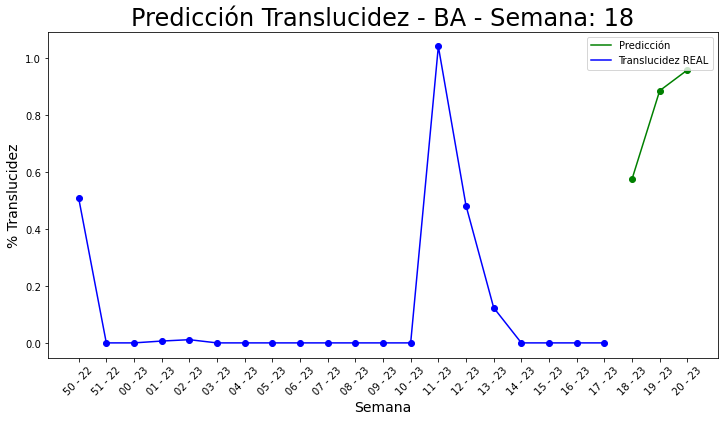

In [94]:
# Graficamos las predicciones

from matplotlib.pyplot import figure

fig, ax  = plt.subplots(figsize=(12,6)) 

aux = plt.plot(ts_pred .index,ts_pred .values, label = 'Predicción', color='green')

aux = plt.plot(ts_trans.index[-20:], ts_trans.values[-20:], label = "Translucidez REAL", color='blue' )

aux = plt.scatter(ts_pred .index, ts_pred .values,color='green')

aux = plt.scatter(ts_trans.index[-20:], ts_trans.values[-20:],  color='blue' )


formato = mdates.DateFormatter("%W - %y")

ax.xaxis.set_major_formatter(formato)
#ax.plot(df_BA_ts_sem _2022.index[df_BA_ts_sem _2022.index > "01/01/2021"], df_BA_ts_sem _2022.values[df_BA_ts_sem _2022.index > "01/01/2021"], label = "Trasnslucidez 2021", linewidth = 2)
ax.legend(loc="upper left")

xticks = pd.date_range(ts_trans.index[-20:].min(),ts_pred.index.max(), freq='W')
ax.set_xticks(xticks)
ax = plt.xlabel("Semana", size = 14)
ax = plt.ylabel("% Translucidez", size = 14)
plt.xticks(rotation=45)
aux = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
aux = plt.title("Predicción Translucidez - BA - Semana: "+ str(ts_pred.index.min().date().isocalendar().week) , size = 24)
aux = plt.legend(loc=0,)
plt.savefig("Prediccion.png")
plt.show()
plt.show()

### Revision de Predicciones

In [140]:
#Importando base de datos historica de resultados

df_prediccion_his= pd.read_csv("Prediccion_T_BA.csv",)
#df_prediccion_his = df_prediccion_his.rename(columns={"Unnamed: 0": "Fecha"})
df_prediccion_his = df_prediccion_his.drop("Unnamed: 0", axis=1)

In [141]:
#Importando BD predicciones historicas

#df_prediccion_his= pd.read_csv("Prediccion_T_BA.csv",)
#df_prediccion_his = df_prediccion_his.rename(columns={"Unnamed: 0": "Fecha"})
df_prediccion_his["Fecha"] = df_prediccion_his["Fecha"].astype( "datetime64[ns]")
df_prediccion_his = df_prediccion_his.drop("Translucidez", axis=1)
#df_prediccion_his.index = pd.DatetimeIndex(df_prediccion_his.index)
#df_prediccion_his["Translucidez"] = ts_trans
#df_prediccion_his = df_prediccion_his.merge(ts_trans , left_index=True, right_index=True) 

#df_prediccion_his["fecha"] = df_prediccion_his.index
df_prediccion_his = pd.merge(df_prediccion_his, ts_trans, left_on="Fecha", right_index=True)
df_prediccion_his_re = df_prediccion_his.rename(columns={"Translucidez-BA": "Translucidez"})
#df_prediccion_his.index = pd.DatetimeIndex(df_prediccion_his.index)
df_prediccion_his_re ["Semana"]  = df_prediccion_his_re ["Fecha"].dt.week
df_prediccion_his_re ["Sem_anticipadas"] = df_prediccion_his_re ["Semana"] - df_prediccion_his_re ["Semana_Prediccion"]
df_prediccion_his_re .tail(5)

,Fecha,Temp_pro_ac,RAD_pro_ac,Preci_pro_ac,HR_pro_ac,GDD_pro_ac,HW,prediccion,modelo,Semana_Prediccion,Semana,Sem_anticipadas,mse,rmse,re,mae,Translucidez
33,2023-04-16,500.870514,341.620459,352.217143,1215.410833,210.043571,0.096353,0.013429,RandomForestRegressor(),12.0,15,3.0,0.000180,0.013429,100.0,0.013429,0.0
34,2023-04-16,500.870514,341.620459,352.217143,1215.410833,210.043571,0.096353,0.549164,SVR(),13.0,15,2.0,0.301581,0.549164,100.0,0.549164,0.0
35,2023-04-16,500.870514,341.620459,352.217143,1215.410833,210.043571,0.096353,0.008711,RandomForestRegressor(),14.0,15,1.0,0.000076,0.008711,100.0,0.008711,0.0
36,2023-04-23,500.966466,342.745537,341.874286,1004.468333,208.684286,0.000000,0.140130,RandomForestRegressor(),15.0,16,1.0,0.019637,0.140130,100.0,0.140130,0.0
37,2023-04-30,501.512895,348.771166,325.064762,1080.945833,208.577976,0.690456,0.622629,LinearRegression(),16.0,17,1.0,0.387667,0.622629,100.0,0.622629,0.0


In [142]:
# Inicializar las columnas de errores en el DataFrame
#df_prediccion_his_re ['mse'] = 0
#df_prediccion_his_re ['rmse'] = 0
#df_prediccion_his_re ['re'] = 0
#df_prediccion_his_re ['corr'] = 0
#df_prediccion_his_re ['mae'] = 0
# Iterar por cada fila del DataFrame y calcular los errores
for i, fila in df_prediccion_his_re .iterrows():
    real = fila['Translucidez']
    predicho = fila['prediccion']
    #from sklearn.metrics import mean_absolute_error
    #print (real, predicho,)
    mae = np.mean(np.abs(real - predicho ))
    
    mse = np.square(real - predicho).mean()
    rmse = np.sqrt(mse)
    if real == 0:
        re = 100
    else:
        re = np.abs((real - predicho) / real) * 100
    
    #re = np.abs((real - predicho) / real) * 100
    #corr = np.corrcoef([real, predicho])[0, 1]
    
    # Asignar los resultados a las columnas correspondientes en la fila actual
    df_prediccion_his_re .at[i, 'mse'] = mse
    df_prediccion_his_re .at[i, 'rmse'] = rmse
    df_prediccion_his_re .at[i, 're'] = re
    df_prediccion_his_re .at[i, 'mae'] = mae
    #df_prediccion_his_re .at[i, 'corr'] = corr

# Mostrar el DataFrame con las nuevas columnas de errores


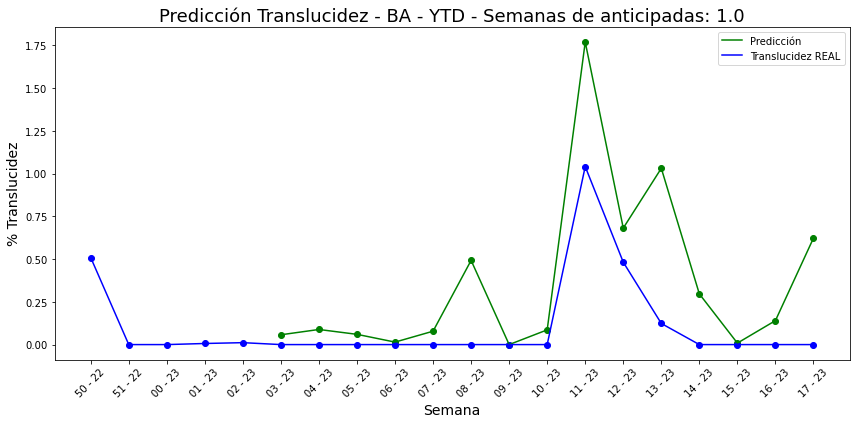

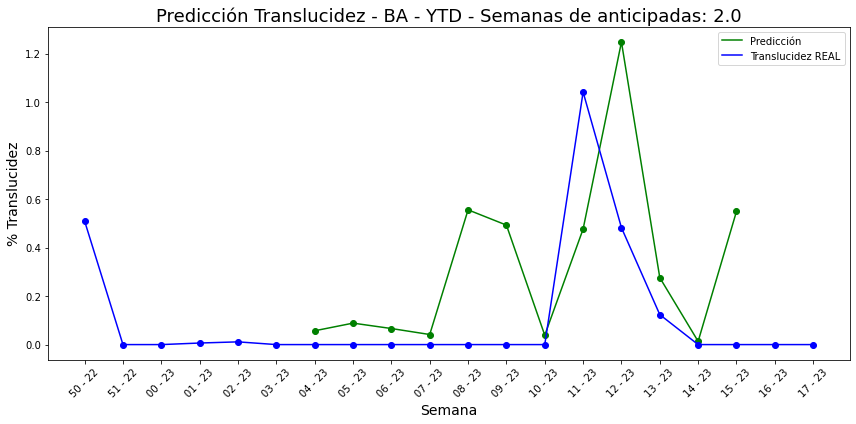

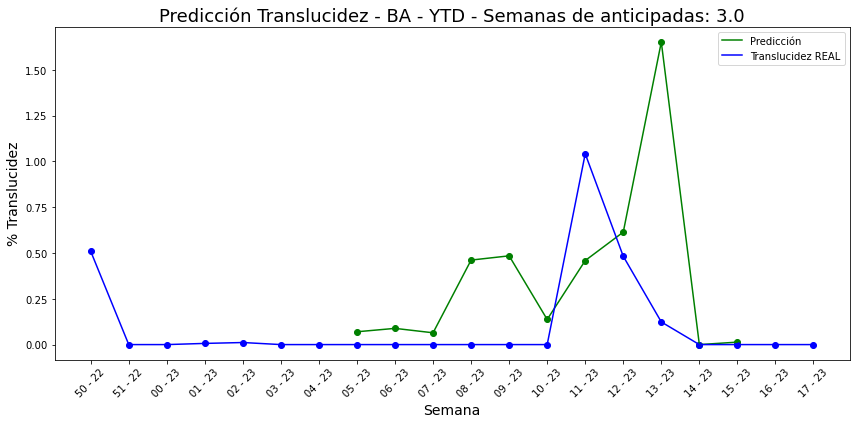

In [146]:
# Graficamos las predicciones

df_prediccion_his_re .index = pd.DatetimeIndex(df_prediccion_his_re .Fecha)

for i in df_prediccion_his_re ["Sem_anticipadas"].unique(): 

    from matplotlib.pyplot import figure

    df_1sem = df_prediccion_his_re .loc [df_prediccion_his_re ["Sem_anticipadas"]== i]
    ts_sem = pd.Series(df_1sem["prediccion"], df_1sem.index )

    fig, ax  = plt.subplots(figsize=(12,6)) 

    aux = plt.plot(ts_sem .index,ts_sem  .values, label = 'Predicción', color='green')

    aux = plt.plot(ts_trans.index[-20:], ts_trans.values[-20:], label = "Translucidez REAL", color='blue' )

    aux = plt.scatter(ts_sem  .index, ts_sem  .values,color='green')

    aux = plt.scatter(ts_trans.index[-20:], ts_trans.values[-20:],  color='blue' )


    formato = mdates.DateFormatter("%W - %y")

    ax.xaxis.set_major_formatter(formato)
    #ax.plot(df_BA_ts_sem _2022.index[df_BA_ts_sem _2022.index > "01/01/2021"], df_BA_ts_sem _2022.values[df_BA_ts_sem _2022.index > "01/01/2021"], label = "Trasnslucidez 2021", linewidth = 2)
    ax.legend(loc="upper left")

    xticks = pd.date_range(ts_trans.index[-20:].min(),ts_trans .index.max(), freq='W')
    ax.set_xticks(xticks)
    ax = plt.xlabel("Semana", size = 14)
    ax = plt.ylabel("% Translucidez", size = 14)
    plt.xticks(rotation=45)
    aux = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    aux = plt.title(f"Predicción Translucidez - BA - YTD - Semanas de anticipadas: {i}", size = 18)
    aux = plt.legend(loc=0,)
    plt.tight_layout()   
    plt.savefig("PrediccionYTD" + str(i) + ".png")
    plt.show()

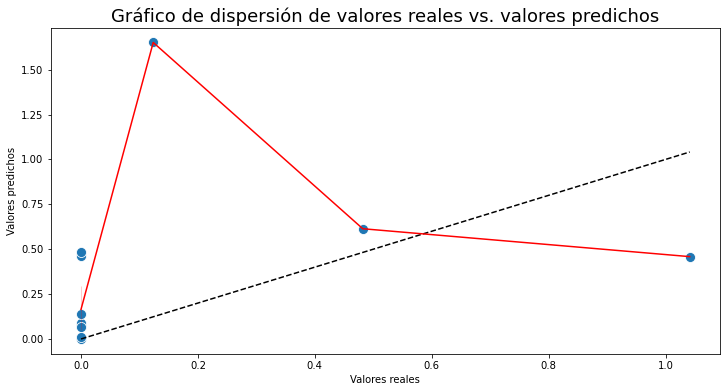

In [147]:
# Gráfico de dispersión
fig, ax  = plt.subplots(figsize=(12,6)) 
sns.scatterplot(x=ts_trans.loc[ ts_sem .index[0].date(): ts_sem .index[len( ts_sem )-1].date():], y=ts_sem, s=100)
sns.lineplot(x=ts_trans.loc[ ts_sem .index[0].date(): ts_sem .index[len( ts_sem )-1].date():], y=ts_trans.loc[ ts_sem .index[0].date(): ts_sem .index[len( ts_sem )-1].date():], color='black', linestyle='--')
sns.lineplot(x=ts_trans.loc[ ts_sem .index[0].date(): ts_sem .index[len( ts_sem )-1].date():], y=ts_sem, color='red')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Gráfico de dispersión de valores reales vs. valores predichos' ,size = 18)
plt.show()

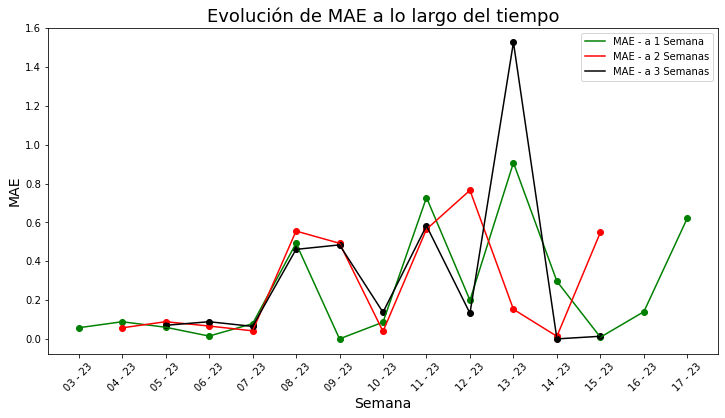

In [148]:
# Graficamos las predicciones


from matplotlib.pyplot import figure

fig, ax  = plt.subplots(figsize=(12,6)) 

df_1sem = df_prediccion_his_re.loc [df_prediccion_his_re["Sem_anticipadas"]== 1]

df_1sem= df_1sem.dropna()

df_2sem = df_prediccion_his_re.loc [df_prediccion_his_re["Sem_anticipadas"]== 2]
df_2sem = df_2sem.dropna()

df_3sem = df_prediccion_his_re.loc [df_prediccion_his_re["Sem_anticipadas"]== 3]
df_3sem = df_3sem.dropna()


aux = plt.plot(df_1sem.index ,df_1sem['mae'] .values, label = 'MAE - a 1 Semana', color='green')

aux = plt.plot(df_2sem.index ,df_2sem['mae'].values, label = 'MAE - a 2 Semanas', color='red')

aux = plt.plot(df_3sem.index ,df_3sem['mae'].values, label = 'MAE - a 3 Semanas', color='black')


#aux = plt.plot(ts_trans.index[-20:], ts_trans.values[-20:], label = "Translucidez REAL", color='blue' )

#aux = plt.scatter(ts_1sem  .index, ts_1sem  .values,color='green')

aux =plt.scatter(df_1sem.index ,df_1sem['mae'] .values,  color='green')
aux =plt.scatter(df_2sem.index ,df_2sem['mae'] .values,  color='red')
aux =plt.scatter(df_3sem.index ,df_3sem['mae'] .values,  color='black')

formato = mdates.DateFormatter("%W - %y")

ax.xaxis.set_major_formatter(formato)
#ax.plot(df_BA_ts_sem _2022.index[df_BA_ts_sem _2022.index > "01/01/2021"], df_BA_ts_sem _2022.values[df_BA_ts_sem _2022.index > "01/01/2021"], label = "Trasnslucidez 2021", linewidth = 2)
ax.legend(loc="upper left")
plt.ylabel('MAE', size = 14)
xticks = pd.date_range(df_1sem.index.min(),df_1sem .index.max(), freq='W')
ax.set_xticks(xticks)
ax = plt.xlabel("Semana", size = 14)
plt.xticks(rotation=45)
aux = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
aux = plt.title("Evolución de MAE a lo largo del tiempo", size = 18)
aux = plt.legend(loc=0,)
plt.savefig("MAE.png")
plt.show()

In [149]:
# Errores YTD
df_errores = pd.DataFrame()
for i in df_prediccion_his_re["Sem_anticipadas"].unique(): 
    df_1sem = df_prediccion_his_re.loc [df_prediccion_his_re["Sem_anticipadas"]== i]
    ts_sem = pd.Series(df_1sem["prediccion"], df_1sem.index )
    error = ts_mod.ts_error([ ts_sem ],  ts_trans.loc[ ts_sem .index[0].date(): ts_sem .index[len( ts_sem )-1].date():], [f"Semana: {i}" ])
    df_error_sem = error.df_errores()
    df_errores = df_errores.append(df_error_sem )
    

In [150]:
df_errores = df_errores.drop("CORR", axis=1)
df_errores 

,MAE,MSE,RMSE,RE
Semana: 1.0,0.252023,0.144007,0.379483,2.295584
Semana: 2.0,0.282138,0.150029,0.387335,2.055909
Semana: 3.0,0.323734,0.288523,0.537144,2.162434


In [151]:
df_errores["Semanas"] = df_errores.index
df_errores

,MAE,MSE,RMSE,RE,Semanas
Semana: 1.0,0.252023,0.144007,0.379483,2.295584,Semana: 1.0
Semana: 2.0,0.282138,0.150029,0.387335,2.055909,Semana: 2.0
Semana: 3.0,0.323734,0.288523,0.537144,2.162434,Semana: 3.0


In [152]:
df_errores = df_errores.round(decimals=2)
#df_errores.insert(0, "Semanas anticipadas", df.pop('Semanas anticipadas'))
df_pdf_error = df_errores 
df_pdf_error

,MAE,MSE,RMSE,RE,Semanas
Semana: 1.0,0.25,0.14,0.38,2.30,Semana: 1.0
Semana: 2.0,0.28,0.15,0.39,2.06,Semana: 2.0
Semana: 3.0,0.32,0.29,0.54,2.16,Semana: 3.0


In [155]:
df_errores_ulti_Sem = df_prediccion_his_re.loc[df_prediccion_his_re["Semana"] == df_prediccion_his_re["Semana"].max()][["Sem_anticipadas", "Semana","mae", "mse", "rmse", "re"]]
df_errores_ulti_Sem = df_errores_ulti_Sem.rename( columns={"mae" : "MAE","mse" : "MSE", "rmse" : "RMSE"	, "re" : "RE" , "Sem_anticipadas": "Semanas anticipadas de predicción"})
df_errores_ulti_Sem = df_errores_ulti_Sem.reset_index(drop=True)
df_errores_ulti_Sem.index = df_errores_ulti_Sem["Semanas anticipadas de predicción"]
df_errores_ulti_Sem = df_errores_ulti_Sem.drop("Semanas anticipadas de predicción", axis=1)
#df_errores_ulti_Sem["Semana"] 

In [156]:
df_errores_ulti_Sem = df_errores_ulti_Sem.round(2)
df_errores_ulti_Sem

,Semana,MAE,MSE,RMSE,RE
Semanas anticipadas de predicción,,,,,
1.0,17,0.62,0.39,0.62,100.0


## Respaldo de resultados

In [157]:
df_pred = df_pred.drop("fechas", axis = 1)


KeyError: "['fechas'] not found in axis"

In [110]:
df_prediccion_his= df_prediccion_his.append (df_pred)

In [111]:
df_prediccion_his.to_csv("Prediccion_T_BA.csv")

## Ceración de PDF

In [173]:
from fpdf import FPDF

def create_pdf_with_text(text,filename):
    # Create a new PDF object
    pdf = FPDF()
    # Add a page to the PDF
    pdf.add_page()
    # Set the font and font size
    pdf.set_font('Arial', '', 12)
    # Insert the text into the PDF
    pdf.multi_cell(0, 10, text)
    # Save the PDF file
    pdf.output(filename, 'F')


In [185]:
from fpdf import FPDF
from PIL import Image
import glob
import os

# 1. Set up the PDF doc basics
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 20 )

# 2. Layout the PDF doc contents
## Title
#pdf.multi_cell(45, 10, 'Reporte Semanal de Picudo ' + "\nFecha de Creación: " +  str(datetime.datetime.now().strftime("%d-%m-%Y")))
pdf.cell(40, 10, 'Predicción Semanal de Translucidez ' + str(datetime.now().strftime("%d-%m-%Y")))
pdf.ln(20)
pdf.image("sf.png", w=30, h=25, x=175, y=30)
pdf.image("dm.png", w=30, h=25,x=10, y=30)

## Line breaks
pdf.ln(20)
pdf.set_font('Arial', 'B', 18 )
pdf.cell(40, 10, 'Semana ' +str(datetime.now().isocalendar().week-1))
pdf.ln(20)


#Agregando emcabezado de reporte
pdf.set_font('Arial', 'B', 16 )
pdf.cell(40, 10, 'Semanas de predicción - Desde : ' + str(ts_pred.index.min().date().isocalendar().week) + " - Hasta: " + str(ts_pred.index.max().date().isocalendar().week ))
pdf.ln(10)
pdf.set_font('Arial', 'B', 12 )
pdf.cell(40, 10, "Gráfico de Predicción a 3 semanas")
pdf.ln(10)

#imageFile = str("Prediccion.png" )
pdf.image("Prediccion.png", w=160, h=80) 
pdf.ln(10) 
output_df_to_pdf(pdf, df_pred_pdf)
pdf.ln(10) 
pdf.set_font('Arial', 'B', 12 )
pdf.cell(40, 10, "Error de última semana")
pdf.ln(10)
output_df_to_pdf(pdf,df_errores_ulti_Sem)

#over = Image.open(imageFile)
#width, height = cover.size
# convert pixel in mm with 1px=0.264583 mm
#width, height = float(width * 0.264583), float(height * 0.264583)
# given we are working with A4 format size 
#pdf_size = {'P': {'w': 210, 'h': 297}, 'L': {'w': 297, 'h': 210}}
# get page orientation from image size 
#orientation = 'P' if width < height else 'L'
#  make sure image size is not greater than the pdf format size
#width = width if width < pdf_size[orientation]['w'] else pdf_size[orientation]['w']
#height = height if height < pdf_size[orientation]['h'] else pdf_size[orientation]['h']
#pdf.add_page(orientation=orientation)
#pdf.image(imageFile, 0, 0, width, height) 
pdf.add_page()    
pdf.set_font('Arial', 'B', 16 )
pdf.cell(40, 10, "Comparativo de Real vrs Predicción")
pdf.ln(10)
pdf.set_font('Arial', '', 10)
text = "Gráfico comparativo 1,2 y 3 semanas de anticipación"
pdf.multi_cell(0, 10, text)
pdf.ln(20)
pdf.set_font('Arial', 'B', 12 )
pdf.image("PrediccionYTD1.png", w=160, h=80)  
pdf.ln(20)
pdf.image("PrediccionYTD2.png", w=160, h=80)  
pdf.ln(20)
pdf.image("PrediccionYTD3.png", w=160, h=80)  
pdf.ln(20)
pdf.set_font('Arial', 'B', 18 )
pdf.cell(40, 10, "Error YTD")
pdf.ln(20)
output_df_to_pdf(pdf, df_pdf_error)
pdf.ln(20)
pdf.image("MAE.png", w=160, h=80)  
pdf.ln(20)
#pdf.add_page()
pdf.set_font('Arial', 'B', 18 )
pdf.cell(40, 10, "Axeno")
pdf.ln(20)
pdf.set_font('Arial', 'B', 12 )
pdf.cell(20, 10, "Error Absoluto Medio (MAE) ")
pdf.ln(10)
pdf.set_font('Arial', '', 10)
text = "Error Absoluto Medio (MAE, por sus siglas en inglés) es una métrica comúnmente utilizada para evaluar la precisión de las predicciones de un modelo de aprendizaje automático. Es una medida de la diferencia promedio absoluta entre los valores predichos y los valores reales."
# Insert the text into the PDF
pdf.multi_cell(0, 10, text)
pdf.ln(20)
pdf.set_font('Arial', 'B', 12 )
pdf.cell(20, 10, "Mean Squared Error (MSE)")
pdf.set_font('Arial', '', 10)
pdf.ln(10)
text = "Es el error cuadrático medio, que mide la diferencia entre los valores reales y los predichos al cuadrado, y se promedia para obtener un valor único. Cuanto menor sea el MSE, mejor será el modelo."
pdf.multi_cell(0, 10, text)
pdf.set_font('Arial', 'B', 12 )
pdf.ln(20)
pdf.cell(20, 10, "Root Mean Squared Error (RMSE) ")
pdf.ln(10)
pdf.set_font('Arial', '', 10)
text ="Es la raíz cuadrada del MSE, que representa la desviación estándar de los errores entre los valores reales y los predichos. Es una medida de la precisión del modelo y cuanto menor sea el RMSE, mejor será el modelo."
pdf.multi_cell(0, 10, text)
pdf.ln(20)
pdf.set_font('Arial', 'B', 12 )
pdf.cell(20, 10, "Relative Error (RE):")
pdf.ln(10)
pdf.set_font('Arial', '', 10)
text = "Es una medida de la precisión relativa del modelo, que se expresa en porcentaje y se calcula como el error absoluto dividido por el valor real. Se utiliza para comparar el rendimiento del modelo en diferentes escalas y puede ser útil en aplicaciones donde el error absoluto es menos importante que el error relativo."
pdf.multi_cell(0, 10, text)

#create_pdf_with_text(text,'Reporte Semana ' + str(ts_pred.index.min().date().isocalendar().week)+'.pdf')
pdf.output('Reporte'+str('Semana ' + str(ts_pred.index.min().date().isocalendar().week))+'.pdf', 'F')

''